In [1]:
import pandas as pd
import autograd.numpy as np
#import numpy as np
from autograd import grad, hessian
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt


filename = 'Data_for_gchoice.csv';

GOV = pd.read_csv(filename)
GOV

,win,dcn,drn,diffc,diffr,lndiffc,index,n,cash,roy,oroy,ocash
0,0,0.558,0.180,52.65585,-0.033333,0.105675,0.296,1,525.0729,0.166667,0.200000,472.4170
1,1,0.442,0.812,-52.65585,0.033333,-0.105675,0.296,1,472.4170,0.200000,0.166667,525.0729
2,0,0.526,0.180,22.13177,-0.033333,0.043064,0.200,2,525.0729,0.166667,0.200000,502.9411
3,1,0.474,0.812,-22.13177,0.033333,-0.043064,0.200,2,502.9411,0.200000,0.166667,525.0729
4,0,0.458,0.418,-150.68920,0.000000,-0.082144,0.878,3,1760.1450,0.200000,0.200000,1910.8350
...,...,...,...,...,...,...,...,...,...,...,...,...
1441,1,0.310,0.788,-263.60470,0.030000,-0.345916,0.972,721,637.8293,0.250000,0.220000,901.4340
1442,0,0.318,0.418,-199.01900,0.000000,-0.320929,0.782,722,525.9387,0.230000,0.230000,724.9577
1443,1,0.680,0.418,199.01900,0.000000,0.320929,0.782,722,724.9577,0.230000,0.230000,525.9387
1444,0,0.386,0.708,-248.37060,0.017500,-0.193218,0.828,723,1165.2530,0.220000,0.202500,1413.6230


In [2]:
def nchoosek(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def bernstein_bases_univariate(x, nx) :
    # sample size
    try:
        numS = len(x)
    except:
        numS = 1
    B = np.empty([numS, nx+1])
    for p in range(nx + 1):
        B[:,p] = ( nchoosek(nx,p)* x ** p ) * ((1-x) ** (nx-p)) 
    return B

def bernstein_bases_trivariate(x, y, z, nx, ny, nz) :
    
    # sample size
    try:
        numS = len(x)
    except:
        numS = 1

    Bx = bernstein_bases_univariate( x, nx )
    By = bernstein_bases_univariate( y, ny )
    Bz = bernstein_bases_univariate( z, nz )

    Bxym  = np.zeros((numS, nx+1, ny+1))
    Bxy   = np.zeros((numS, (nx+1)*(ny+1)))
    Bxyzm = np.zeros((numS, (nx+1)*(ny+1), nz+1))
    Bxyz  = np.zeros((numS, (nx+1)*(ny+1)*(nz+1)))

    for i in range(numS):
        Bxym[i,:,:] = np.outer(Bx[i,:], By[i,:])

    for i in range(numS):
        Bxy[i,:] = Bxym[i,:,:].flatten()
    
    for i in range(numS):
        Bxyzm[i,:,:] = np.outer(Bxy[i,:], Bz[i,:])

    for i in range(numS):
        Bxyz[i,:] = Bxyzm[i,:,:].flatten()

    return Bxyz

def gchoice_L(beta) :
    P = bases @ beta
    P = np.maximum(0.000001, P)
    P = np.minimum(0.99999, P)
    L = np.sum(win * np.log(P) + (1-win) * np.log(1-P))
    return -L

In [3]:
x = GOV.drn.array.to_numpy()
y = GOV.dcn.array.to_numpy()
z = GOV['index'].array.to_numpy()
win = GOV.win.array.to_numpy()

nx = 6
ny = 6
nz = 2

beta = pd.read_csv('Berstein_parameters.csv', header=None).values

bases = bernstein_bases_trivariate(x, y, z, nx, ny, nz)

numS = bases.shape[0]

grad_gchoice_L = grad(gchoice_L)


init = tuple([0.5]*147)
result = minimize(gchoice_L, init, method='SLSQP', bounds=[(0,1)]*147, jac=grad_gchoice_L)
beta = result.x if result.success else np.nan


In [3]:
def gchoice_fun(dcn, drn, index = 0.5):
    return (bernstein_bases_trivariate(dcn, drn, index, nx, ny, nz) @ beta)[0]

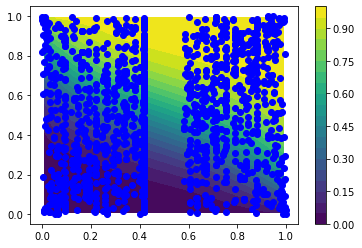

In [5]:
a = np.linspace(0.01, 0.99, 50)
b = np.linspace(0.01, 0.99, 50)
A, B = np.meshgrid(a, b)

f = np.frompyfunc(gchoice_fun, 2, 1)
P = f(A, B)

im = plt.contourf(A, B, P, 20, cmap='viridis')
plt.colorbar(im)
plt.scatter(x, y, c ="blue")

In [100]:


beta = pd.read_csv('Berstein_parameters.csv', header=None)[0].array.to_numpy()

beta

array([6.96537558e-08, 2.05569433e-02, 2.05570486e-02, 2.05570887e-02,
       2.05571347e-02, 2.05572705e-02, 9.30878120e-02, 1.12959052e-07,
       2.05569640e-02, 2.05570787e-02, 2.05571426e-02, 2.05572182e-02,
       2.05573837e-02, 9.30880831e-02, 1.72630322e-07, 2.05569935e-02,
       2.05571264e-02, 2.05572353e-02, 2.05573804e-02, 2.05576531e-02,
       7.14626516e-01, 3.29578523e-07, 2.05571087e-02, 2.05575659e-02,
       6.38924425e-01, 9.77866608e-01, 9.77867136e-01, 9.99999642e-01,
       3.86345180e-01, 9.77866712e-01, 9.77866939e-01, 9.77867052e-01,
       9.77867145e-01, 9.77867284e-01, 9.99999826e-01, 9.19091636e-01,
       9.77866956e-01, 9.77867085e-01, 9.77867143e-01, 9.77867198e-01,
       9.77867320e-01, 9.99999898e-01, 9.19091884e-01, 9.77867061e-01,
       9.77867159e-01, 9.77867195e-01, 9.77867230e-01, 9.77867345e-01,
       9.99999949e-01, 1.15801367e-08, 5.24263923e-08, 9.15823225e-08,
       1.30555551e-07, 1.84513815e-07, 2.90591801e-07, 5.26884172e-07,
      

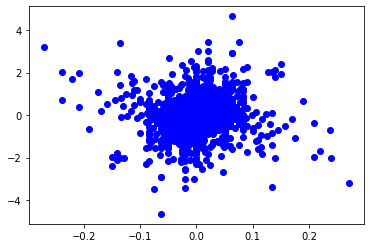

In [17]:
plt.scatter(GOV.diffr,GOV.lndiffc,c ="blue")

In [14]:
beta_hat


True

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 

In [35]:
x = GOV.drn.array.to_numpy()
y = GOV.dcn.array.to_numpy()
z = GOV['index'].array.to_numpy()
win = GOV.win.array.to_numpy()

nx = 6
ny = 6
nz = 2

beta = pd.read_csv('Berstein_parameters.csv', header=None).values

bases = bernstein_bases_trivariate(x, y, z, nx, ny, nz)


gchoice_likelihood(beta,bases,win)

TypeError: gchoice_likelihood() takes 1 positional argument but 3 were given

In [44]:
pd.read_csv('Berstein_parameters.csv', header=None)[0].array.to_numpy()

array([6.96537558e-08, 2.05569433e-02, 2.05570486e-02, 2.05570887e-02,
       2.05571347e-02, 2.05572705e-02, 9.30878120e-02, 1.12959052e-07,
       2.05569640e-02, 2.05570787e-02, 2.05571426e-02, 2.05572182e-02,
       2.05573837e-02, 9.30880831e-02, 1.72630322e-07, 2.05569935e-02,
       2.05571264e-02, 2.05572353e-02, 2.05573804e-02, 2.05576531e-02,
       7.14626516e-01, 3.29578523e-07, 2.05571087e-02, 2.05575659e-02,
       6.38924425e-01, 9.77866608e-01, 9.77867136e-01, 9.99999642e-01,
       3.86345180e-01, 9.77866712e-01, 9.77866939e-01, 9.77867052e-01,
       9.77867145e-01, 9.77867284e-01, 9.99999826e-01, 9.19091636e-01,
       9.77866956e-01, 9.77867085e-01, 9.77867143e-01, 9.77867198e-01,
       9.77867320e-01, 9.99999898e-01, 9.19091884e-01, 9.77867061e-01,
       9.77867159e-01, 9.77867195e-01, 9.77867230e-01, 9.77867345e-01,
       9.99999949e-01, 1.15801367e-08, 5.24263923e-08, 9.15823225e-08,
       1.30555551e-07, 1.84513815e-07, 2.90591801e-07, 5.26884172e-07,
      

In [74]:
beta[10,0] = 1

In [34]:
x.to

<PandasArray>
[ 0.18, 0.812,  0.18, 0.812, 0.418, 0.418,  0.18, 0.812, 0.996, 0.004,
 ...
 0.754,  0.22, 0.418, 0.418, 0.192, 0.788, 0.418, 0.418, 0.708,  0.29]
Length: 1446, dtype: float64

In [64]:
bases.shape

(1446, 147)

,win,diffr,lndiffc
0,0,-0.033333,0.105675
1,1,0.033333,-0.105675
2,0,-0.033333,0.043064
3,1,0.033333,-0.043064
4,0,0.000000,-0.082144
...,...,...,...
1441,1,0.030000,-0.345916
1442,0,0.000000,-0.320929
1443,1,0.000000,0.320929
1444,0,0.017500,-0.193218


In [29]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer()

GOV_SUB = GOV[['win', 'diffr', 'lndiffc', 'index']]
GOV_X = GOV_SUB[['diffr', 'lndiffc']]
GOV_STD = qt.fit_transform(GOV_X)

x = GOV_STD[:,0]
y = GOV_STD[:,1]
z = GOV['index'].array.to_numpy()

win = GOV.win.array.to_numpy()

nx = 6
ny = 6
nz = 2

beta = pd.read_csv('Berstein_parameters.csv', header=None).values

bases = bernstein_bases_trivariate(x, y, z, nx, ny, nz)

numS = bases.shape[0]

grad_gchoice_L = grad(gchoice_L)


init = tuple([0.5]*147)
result = minimize(gchoice_L, init, method='SLSQP', bounds=[(0,1)]*147, jac=grad_gchoice_L)
beta = result.x if result.success else np.nan

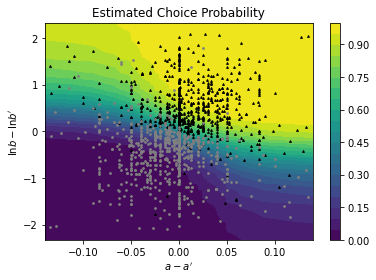

In [68]:
numGRID = 100

a_qt = np.linspace(0.01, 0.99, numGRID)
b_qt = np.linspace(0.01, 0.99, numGRID)
A_qt, B_qt = np.meshgrid(a_qt, b_qt)

f = np.frompyfunc(gchoice_fun, 2, 1)
P = f(A_qt, B_qt)

a = qt.inverse_transform(np.vstack((a_qt, b_qt)).T)[:,0]
b = qt.inverse_transform(np.vstack((a_qt, b_qt)).T)[:,1]
A, B = np.meshgrid(a, b)

im = plt.contourf(A, B, P, 20, cmap='viridis')
plt.colorbar(im)
GOV_PLOT = GOV_SUB[ (GOV_SUB['diffr'] < 0.14) & (GOV_SUB['diffr'] > -0.14) & (GOV_SUB['lndiffc'] < 2.1) & (GOV_SUB['lndiffc'] > -2.1)]
GOV_PLOT_WIN  = GOV_PLOT[GOV_PLOT['win'] == 1]
GOV_PLOT_LOSS = GOV_PLOT[GOV_PLOT['win'] == 0]
plt.scatter(GOV_PLOT_WIN.diffr,GOV_PLOT_WIN.lndiffc,c ="black", marker='^', s=3)
plt.scatter(GOV_PLOT_LOSS.diffr,GOV_PLOT_LOSS.lndiffc,c ="grey", marker='o', s=3)
plt.xlabel(r'$a - a^\prime$')
plt.ylabel(r'$\ln b - \ln b^\prime$')
plt.title('Estimated Choice Probability')
plt.show()


In [40]:
GOV_PLOT = GOV_SUB[ (GOV_SUB['diffr'] < 0.15) & (GOV_SUB['diffr'] > -0.15) & (GOV_SUB['lndiffc'] < 2.1) & (GOV_SUB['lndiffc'] > -2.1)]

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

In [18]:
index

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])